In [2]:
import os

import tensorflow as tf
from tensorflow import keras

import numpy as np
import pandas as pd

import glob
import cv2
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint# early stopping
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model # basic class for specifying and training a neural network

import mlflow

2024-09-30 11:51:50.880632: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-30 11:51:50.883958: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-30 11:51:50.894634: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-30 11:51:50.912002: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-30 11:51:50.916688: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-30 11:51:50.930318: I tensorflow/core/platform/cpu_feature_gu

# Classifying teeth to upper/lower jaw

In [3]:
mnist_model = tf.keras.models.load_model('/home/riikoro/thesis/code/pretrained_base_models/bangla_english_handwritten_mnist.keras')

In [5]:
tooth_labels = pd.read_csv('/home/riikoro/thesis/code/mnist-proof-of-concept/teeth/labels.csv')
type_labels = tooth_labels.iloc[:,4:6]
type_labels

,u,l
0,0,1
1,1,0
2,0,1
3,0,1
4,0,1
5,1,0
6,0,1
7,0,1
8,0,1
9,0,1


In [7]:
for layer in mnist_model.layers[:-1]:
    layer.trainable = False

new_output = Dense(2, activation='softmax')(mnist_model.layers[-2].output)
new_model = Model(mnist_model.input, new_output)
new_model.layers

[<InputLayer name=input_layer_4, built=True>,
 <Conv2D name=conv2d_16, built=True>,
 <Conv2D name=conv2d_17, built=True>,
 <MaxPooling2D name=max_pooling2d_8, built=True>,
 <Dropout name=dropout_12, built=True>,
 <Conv2D name=conv2d_18, built=True>,
 <Conv2D name=conv2d_19, built=True>,
 <MaxPooling2D name=max_pooling2d_9, built=True>,
 <Dropout name=dropout_13, built=True>,
 <Flatten name=flatten_4, built=True>,
 <Dense name=dense_8, built=True>,
 <Dropout name=dropout_14, built=True>,
 <Dense name=dense_1, built=True>]

In [8]:
for layer in new_model.layers:
    print(layer.trainable)

False
False
False
False
False
False
False
False
False
False
False
False
True


In [9]:
def preprocess_img(image: np.array):
    image = image[:,:-12] #remove side pixels to get rid of number
    resized = cv2.resize(image,(28,28))
    colorflipped = 255-resized
    return colorflipped

In [10]:
original_images = glob.glob("/home/riikoro/thesis/code/mnist-proof-of-concept/teeth/*.png")

In [11]:
# convert teeth to images of shape 28x28, black and white
tooth_images = []
for i, filename in enumerate(original_images):
    image = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)
    tooth_images.append(preprocess_img(image))

teeth = np.array(tooth_images)
teeth = teeth.reshape(teeth.shape[0], teeth.shape[1], teeth.shape[2], 1) # add rgb dimension, required by model
teeth.shape

(30, 28, 28, 1)

In [12]:

X_train, X_val, Y_train, Y_val = train_test_split(teeth, type_labels, test_size = 0.1, random_state=2)
print(X_train.shape, X_val.shape, Y_train.shape, Y_val.shape)

(27, 28, 28, 1) (3, 28, 28, 1) (27, 2) (3, 2)


In [13]:
model = new_model

# steps copied from mnist classifier notebook
batch_size = 6 # in each iteration, we consider 128 training examples at once
num_epochs = 150
X_train = X_train.astype('float32')
X_train /= 255 # Normalise data to [0, 1] range

model.compile(loss='categorical_crossentropy', # using the cross-entropy loss function
              optimizer=Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, weight_decay=0.0, amsgrad=False),
              # using the Adam optimiser
              metrics=['accuracy']) # reporting the accuracy
# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)
# With data augmentation to prevent overfitting (accuracy 0.99286)

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

In [14]:
history = model.fit(datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = 50, validation_data = (X_val,Y_val),
                              verbose = 2, steps_per_epoch=X_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction])
model.evaluate(X_train, Y_train, verbose=1) # Evaluate on training data: too little test data

Epoch 1/50


/home/riikoro/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


4/4 - 1s - 266ms/step - accuracy: 0.5714 - loss: 0.7025 - val_accuracy: 0.3333 - val_loss: 32.9540 - learning_rate: 0.0010
Epoch 2/50
4/4 - 0s - 23ms/step - accuracy: 0.3333 - loss: 0.8371 - val_accuracy: 0.3333 - val_loss: 33.1893 - learning_rate: 0.0010
Epoch 3/50
4/4 - 0s - 21ms/step - accuracy: 0.4286 - loss: 0.7386 - val_accuracy: 0.3333 - val_loss: 34.5703 - learning_rate: 0.0010
Epoch 4/50


/home/riikoro/anaconda3/lib/python3.11/site-packages/keras/src/callbacks/callback_list.py:96: UserWarning: Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: accuracy,loss,val_accuracy,val_loss,learning_rate.
  callback.on_epoch_end(epoch, logs)
2024-09-30 11:52:33.540945: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/home/riikoro/anaconda3/lib/python3.11/contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
2024-09-30 11:52:33.705667: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}

4/4 - 0s - 8ms/step - accuracy: 0.5000 - loss: 0.6799 - val_accuracy: 0.3333 - val_loss: 35.0982 - learning_rate: 0.0010
Epoch 5/50
4/4 - 0s - 16ms/step - accuracy: 0.5833 - loss: 0.6774 - val_accuracy: 0.3333 - val_loss: 37.3587 - learning_rate: 0.0010
Epoch 6/50
4/4 - 0s - 7ms/step - accuracy: 0.3333 - loss: 0.8901 - val_accuracy: 0.3333 - val_loss: 37.8801 - learning_rate: 0.0010
Epoch 7/50
4/4 - 0s - 17ms/step - accuracy: 0.5417 - loss: 0.7519 - val_accuracy: 0.3333 - val_loss: 39.6446 - learning_rate: 0.0010
Epoch 8/50
4/4 - 0s - 8ms/step - accuracy: 1.0000 - loss: 0.5885 - val_accuracy: 0.3333 - val_loss: 40.1347 - learning_rate: 0.0010
Epoch 9/50
4/4 - 0s - 16ms/step - accuracy: 0.5417 - loss: 0.6945 - val_accuracy: 0.3333 - val_loss: 41.9378 - learning_rate: 0.0010
Epoch 10/50
4/4 - 0s - 7ms/step - accuracy: 0.6667 - loss: 0.8039 - val_accuracy: 0.3333 - val_loss: 42.2225 - learning_rate: 0.0010
Epoch 11/50
4/4 - 0s - 16ms/step - accuracy: 0.4762 - loss: 0.7495 - val_accuracy: 

2024-09-30 11:52:33.912791: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


4/4 - 0s - 7ms/step - accuracy: 0.6667 - loss: 0.6215 - val_accuracy: 0.3333 - val_loss: 43.5701 - learning_rate: 0.0010
Epoch 13/50
4/4 - 0s - 16ms/step - accuracy: 0.7143 - loss: 0.5581 - val_accuracy: 0.3333 - val_loss: 44.2609 - learning_rate: 0.0010
Epoch 14/50
4/4 - 0s - 7ms/step - accuracy: 0.5000 - loss: 0.7228 - val_accuracy: 0.3333 - val_loss: 44.3118 - learning_rate: 0.0010
Epoch 15/50
4/4 - 0s - 18ms/step - accuracy: 0.5714 - loss: 0.6845 - val_accuracy: 0.3333 - val_loss: 44.4036 - learning_rate: 0.0010
Epoch 16/50
4/4 - 0s - 7ms/step - accuracy: 0.5000 - loss: 0.7313 - val_accuracy: 0.3333 - val_loss: 44.4693 - learning_rate: 0.0010
Epoch 17/50
4/4 - 0s - 15ms/step - accuracy: 0.6667 - loss: 0.6666 - val_accuracy: 0.3333 - val_loss: 44.9521 - learning_rate: 0.0010
Epoch 18/50
4/4 - 0s - 8ms/step - accuracy: 0.5000 - loss: 0.7132 - val_accuracy: 0.3333 - val_loss: 45.2197 - learning_rate: 0.0010
Epoch 19/50
4/4 - 0s - 17ms/step - accuracy: 0.7083 - loss: 0.6250 - val_accur

2024-09-30 11:52:34.316144: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


4/4 - 0s - 7ms/step - accuracy: 0.6667 - loss: 0.7845 - val_accuracy: 0.3333 - val_loss: 46.5240 - learning_rate: 0.0010
Epoch 21/50
4/4 - 0s - 15ms/step - accuracy: 0.5714 - loss: 0.5935 - val_accuracy: 0.3333 - val_loss: 47.0641 - learning_rate: 0.0010
Epoch 22/50
4/4 - 0s - 7ms/step - accuracy: 0.5000 - loss: 0.8120 - val_accuracy: 0.3333 - val_loss: 47.2065 - learning_rate: 0.0010
Epoch 23/50
4/4 - 0s - 16ms/step - accuracy: 0.5714 - loss: 0.7097 - val_accuracy: 0.3333 - val_loss: 47.2559 - learning_rate: 0.0010
Epoch 24/50
4/4 - 0s - 8ms/step - accuracy: 0.5000 - loss: 0.6542 - val_accuracy: 0.3333 - val_loss: 47.1460 - learning_rate: 0.0010
Epoch 25/50
4/4 - 0s - 15ms/step - accuracy: 0.5714 - loss: 0.7002 - val_accuracy: 0.3333 - val_loss: 46.9223 - learning_rate: 0.0010
Epoch 26/50
4/4 - 0s - 7ms/step - accuracy: 0.5000 - loss: 0.8899 - val_accuracy: 0.3333 - val_loss: 46.8305 - learning_rate: 0.0010
Epoch 27/50
4/4 - 0s - 15ms/step - accuracy: 0.5714 - loss: 0.7228 - val_accur

2024-09-30 11:52:35.115692: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


4/4 - 0s - 8ms/step - accuracy: 0.6667 - loss: 0.6094 - val_accuracy: 0.3333 - val_loss: 55.1326 - learning_rate: 0.0010
Epoch 37/50
4/4 - 0s - 28ms/step - accuracy: 0.6190 - loss: 0.6362 - val_accuracy: 0.3333 - val_loss: 55.6148 - learning_rate: 0.0010
Epoch 38/50
4/4 - 0s - 7ms/step - accuracy: 0.6667 - loss: 0.5387 - val_accuracy: 0.3333 - val_loss: 55.5480 - learning_rate: 0.0010
Epoch 39/50
4/4 - 0s - 17ms/step - accuracy: 0.7143 - loss: 0.6305 - val_accuracy: 0.3333 - val_loss: 55.5190 - learning_rate: 0.0010
Epoch 40/50
4/4 - 0s - 8ms/step - accuracy: 0.5000 - loss: 0.8554 - val_accuracy: 0.3333 - val_loss: 55.3843 - learning_rate: 0.0010
Epoch 41/50
4/4 - 0s - 16ms/step - accuracy: 0.6667 - loss: 0.6034 - val_accuracy: 0.3333 - val_loss: 55.2409 - learning_rate: 0.0010
Epoch 42/50
4/4 - 0s - 7ms/step - accuracy: 0.6667 - loss: 0.6838 - val_accuracy: 0.3333 - val_loss: 55.1614 - learning_rate: 0.0010
Epoch 43/50
4/4 - 0s - 16ms/step - accuracy: 0.6250 - loss: 0.6823 - val_accur

[0.6310935020446777, 0.6296296119689941]

In [15]:
test_loss, test_acc = model.evaluate(X_val, Y_val)
test_acc

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.3333 - loss: 55.6063


0.3333333432674408

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━

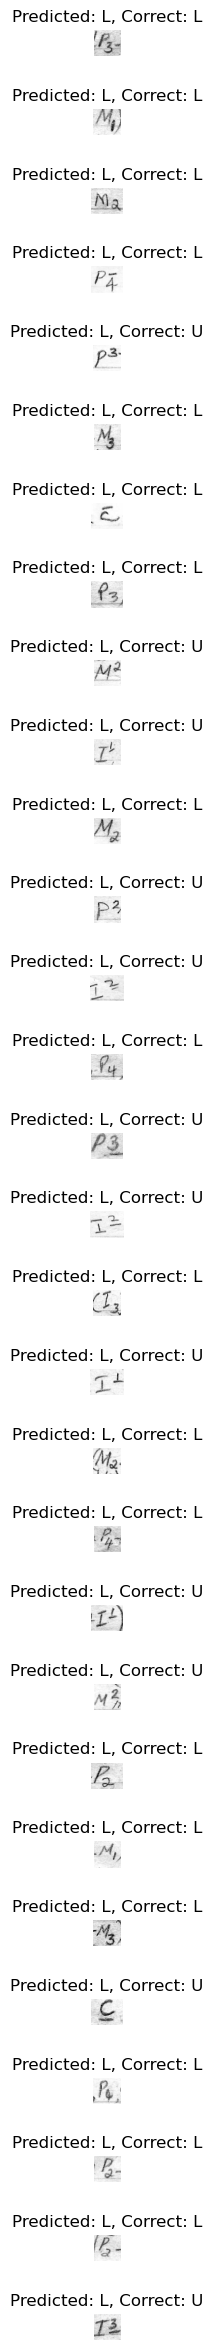

In [21]:
def id_to_upper_lower(id):
    if id == 0:
        return 'U'
    elif id == 1:
        return 'L'

correct = 0
fig, ax = plt.subplots(30, figsize = (500,30))
plt.subplots_adjust(hspace=2)
for i, filename in enumerate(original_images):
    image = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)
    img_num = filename.split('/')[7].split('.')[0]
    loc = int(img_num)
    label = type_labels.iloc[loc]

    preprocessed = preprocess_img(image)
    pred = model.predict(preprocessed.reshape(1,28,28,1))
    pred = id_to_upper_lower(np.argmax(pred))
    truth = id_to_upper_lower(np.argmax(label))
    fig_title = f'Predicted: {pred}, Correct: {truth}'
    if pred == truth:
        correct += 1
    
    ax[i].imshow(image, cmap='gray')
    ax[i].axis('off')
    ax[i].set_title(fig_title)

acc = correct/30
print(f"Accuracy: {acc} %")

In [22]:
%env MLFLOW_TRACKING_URI=sqlite:///../mlflow.db
mlflow.set_experiment("Upper / lower")

params = {
    'data_v': 3,
    'train_size':27,
    'test_size':3,
    'commit_sha': 'fe823c03e82c2094ad871bd7b475601bfab121d4',
    'batch_size': batch_size,
    'num_epochs': num_epochs
}

# Start an MLflow run
with mlflow.start_run():
    # Log the hyperparameters
    mlflow.log_params(params)

    # Log the loss metric
    mlflow.log_metric("training accuracy", acc)
    mlflow.log_metric("test accuracy", test_acc)

    # Set a tag that we can use to remind ourselves what this run was for
    mlflow.set_tag("info", "Initial test on upper/lower classification")

env: MLFLOW_TRACKING_URI=sqlite:///../mlflow.db


2024/09/30 11:56:22 INFO mlflow.tracking.fluent: Experiment with name 'Upper / lower' does not exist. Creating a new experiment.
